In [ ]:
# !pip install crewai easyocr opencv-python-headless pandas

In [ ]:
import os
from dotenv import load_dotenv

# Create a .env file if it doesn't exist
env_file = ".env"
if not os.path.exists(env_file):
    with open(env_file, "w") as f:
        f.write("# Store your API keys and credentials here\n")

# Load environment variables
load_dotenv()

# Set environment variables (Modify this manually in your .env file)
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-openai-api-key")

# Verify loading
print("✅ Environment variables loaded successfully!")

In [ ]:
import os
import pandas as pd

# Define CSV file name
CSV_FILE = "expenses.csv"

# Define function to initialize CSV file
def initialize_csv(file_path):
    if not os.path.exists(file_path):
        df = pd.DataFrame(columns=["Date", "Amount", "Category", "Vendor", "Description"])
        df.to_csv(file_path, index=False)
        print(f"✅ Created new CSV file: {file_path}")
    else:
        print(f"ℹ️ CSV file already exists: {file_path}")

# Call function to ensure CSV file exists
initialize_csv(CSV_FILE)

# Display CSV structure
print("📄 CSV structure initialized:")
pd.read_csv(CSV_FILE).head()

In [ ]:
!pip install easyocr

📂 Found receipt folder: receipts
🖼 Displaying: 2025-01-18-Grocery-Warehouse.jpg


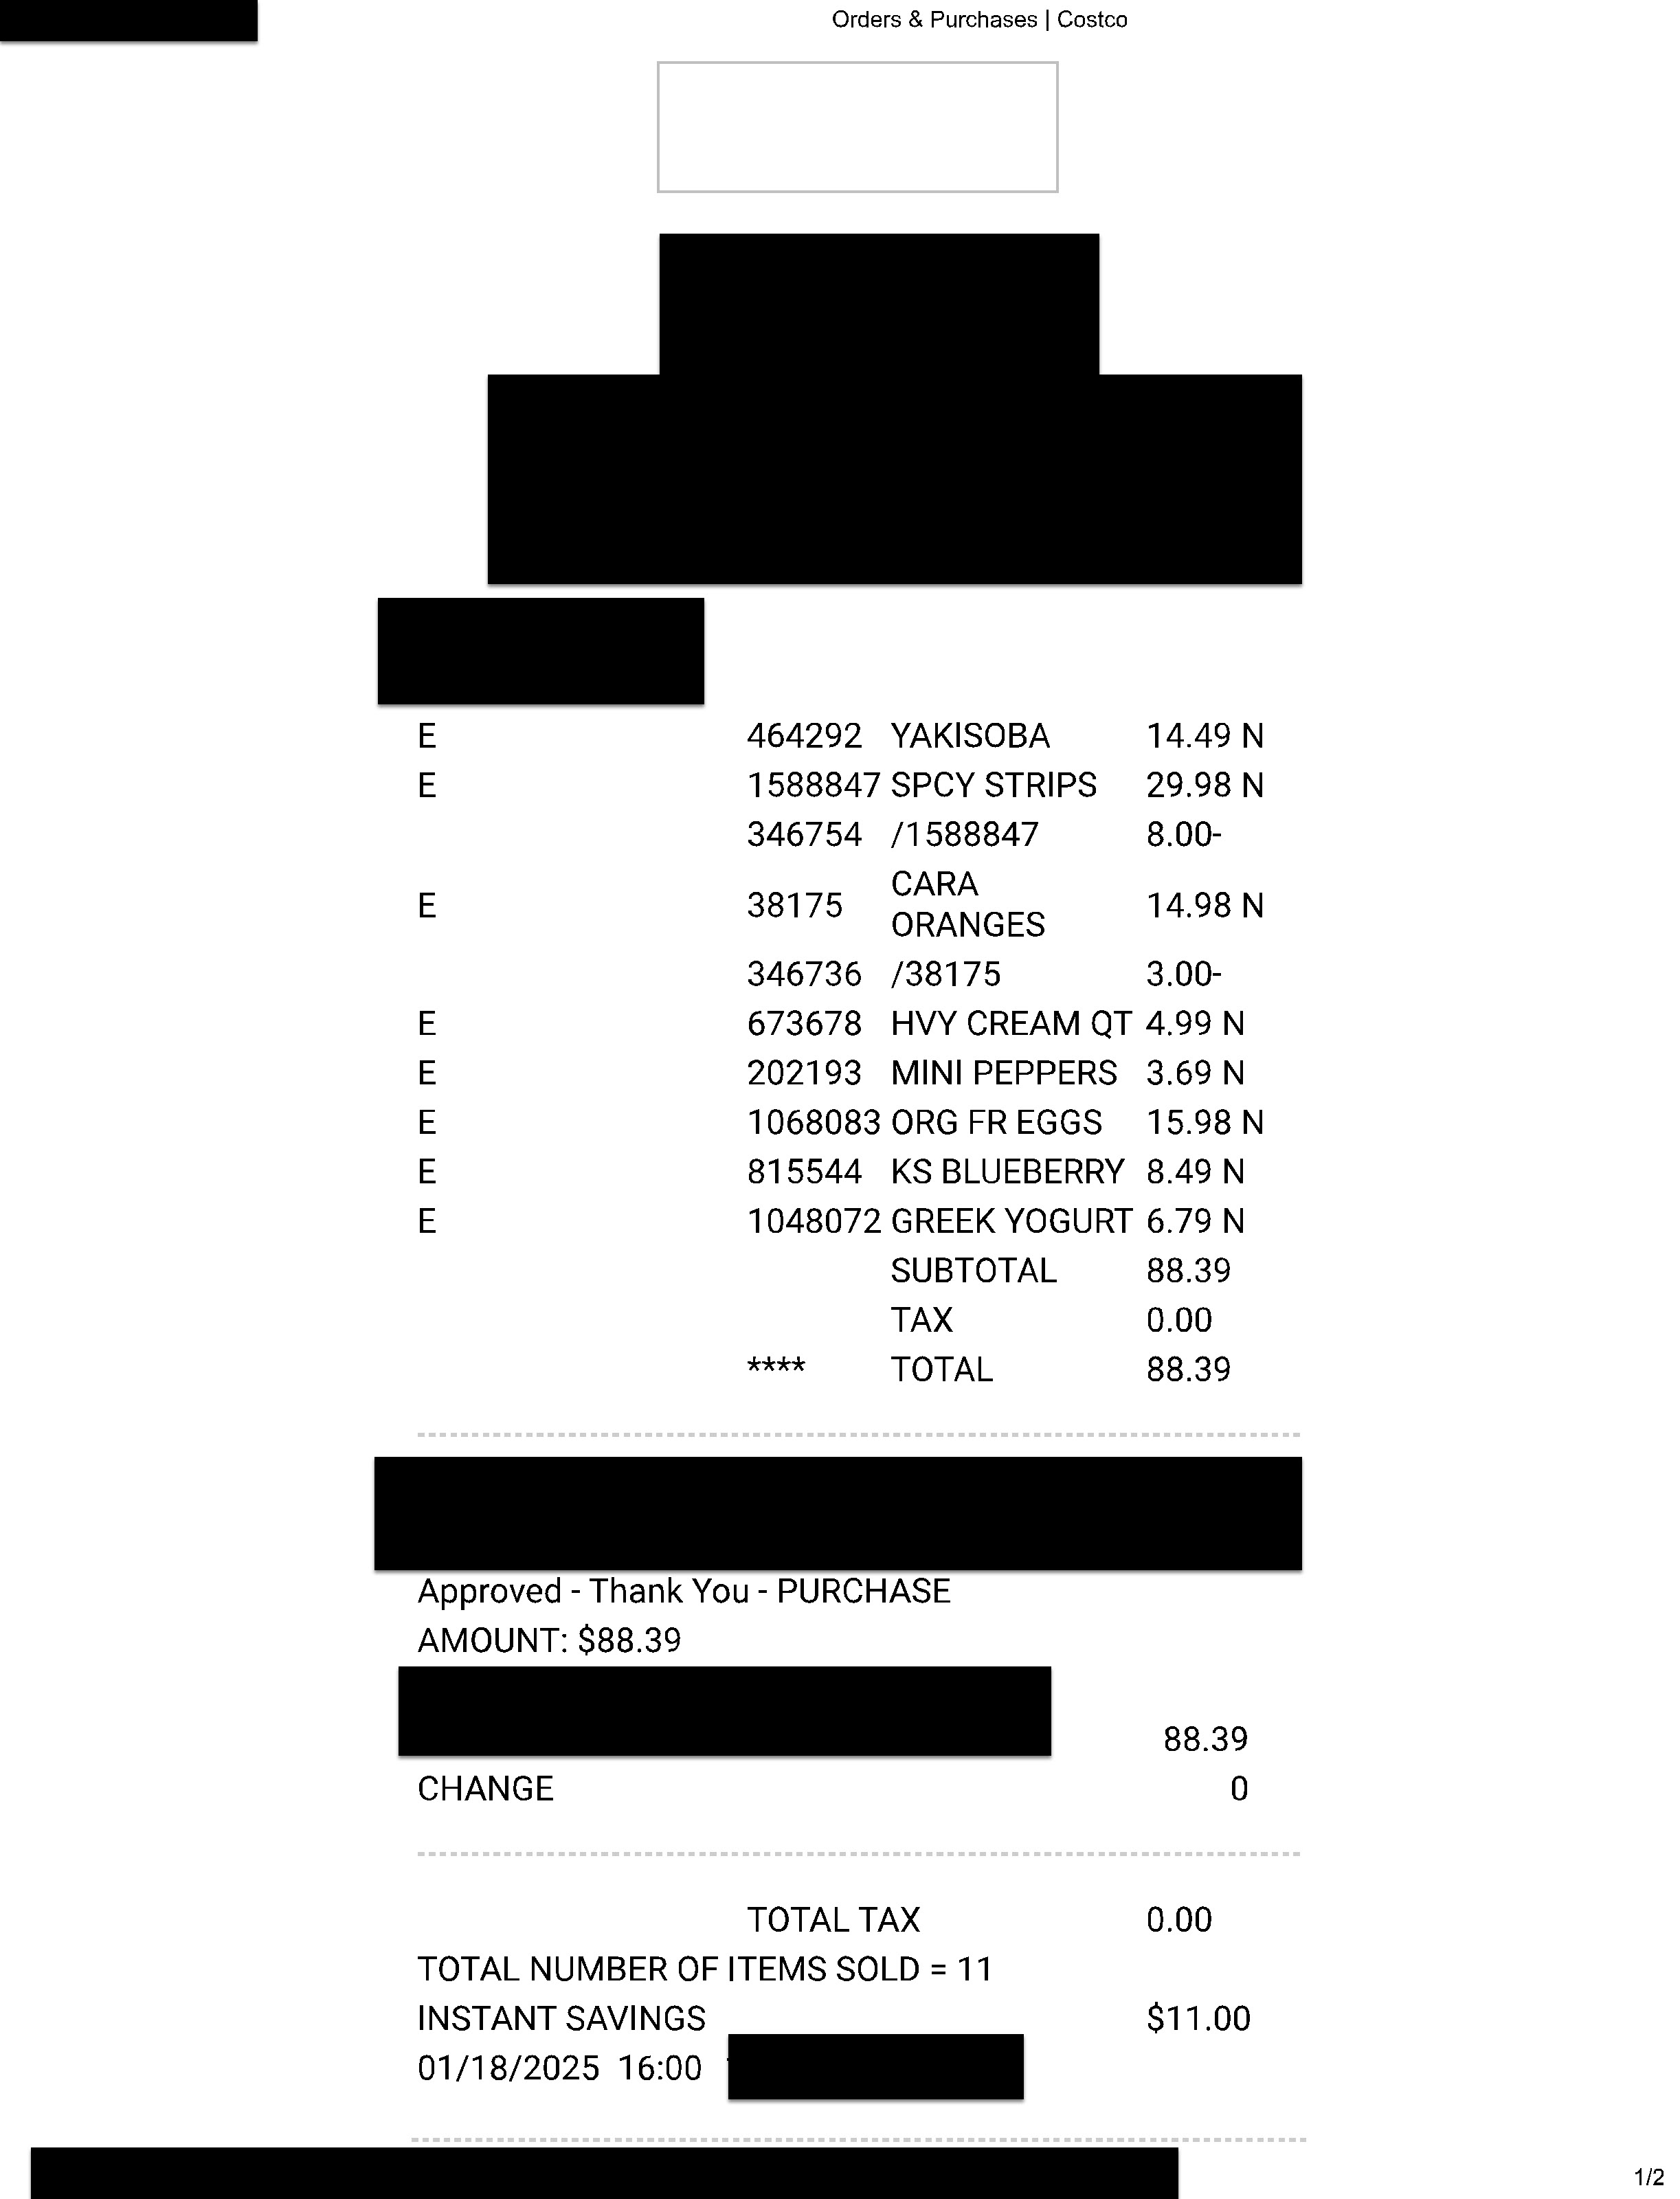

🖼 Displaying: 2025-02-10-Gas.jpg


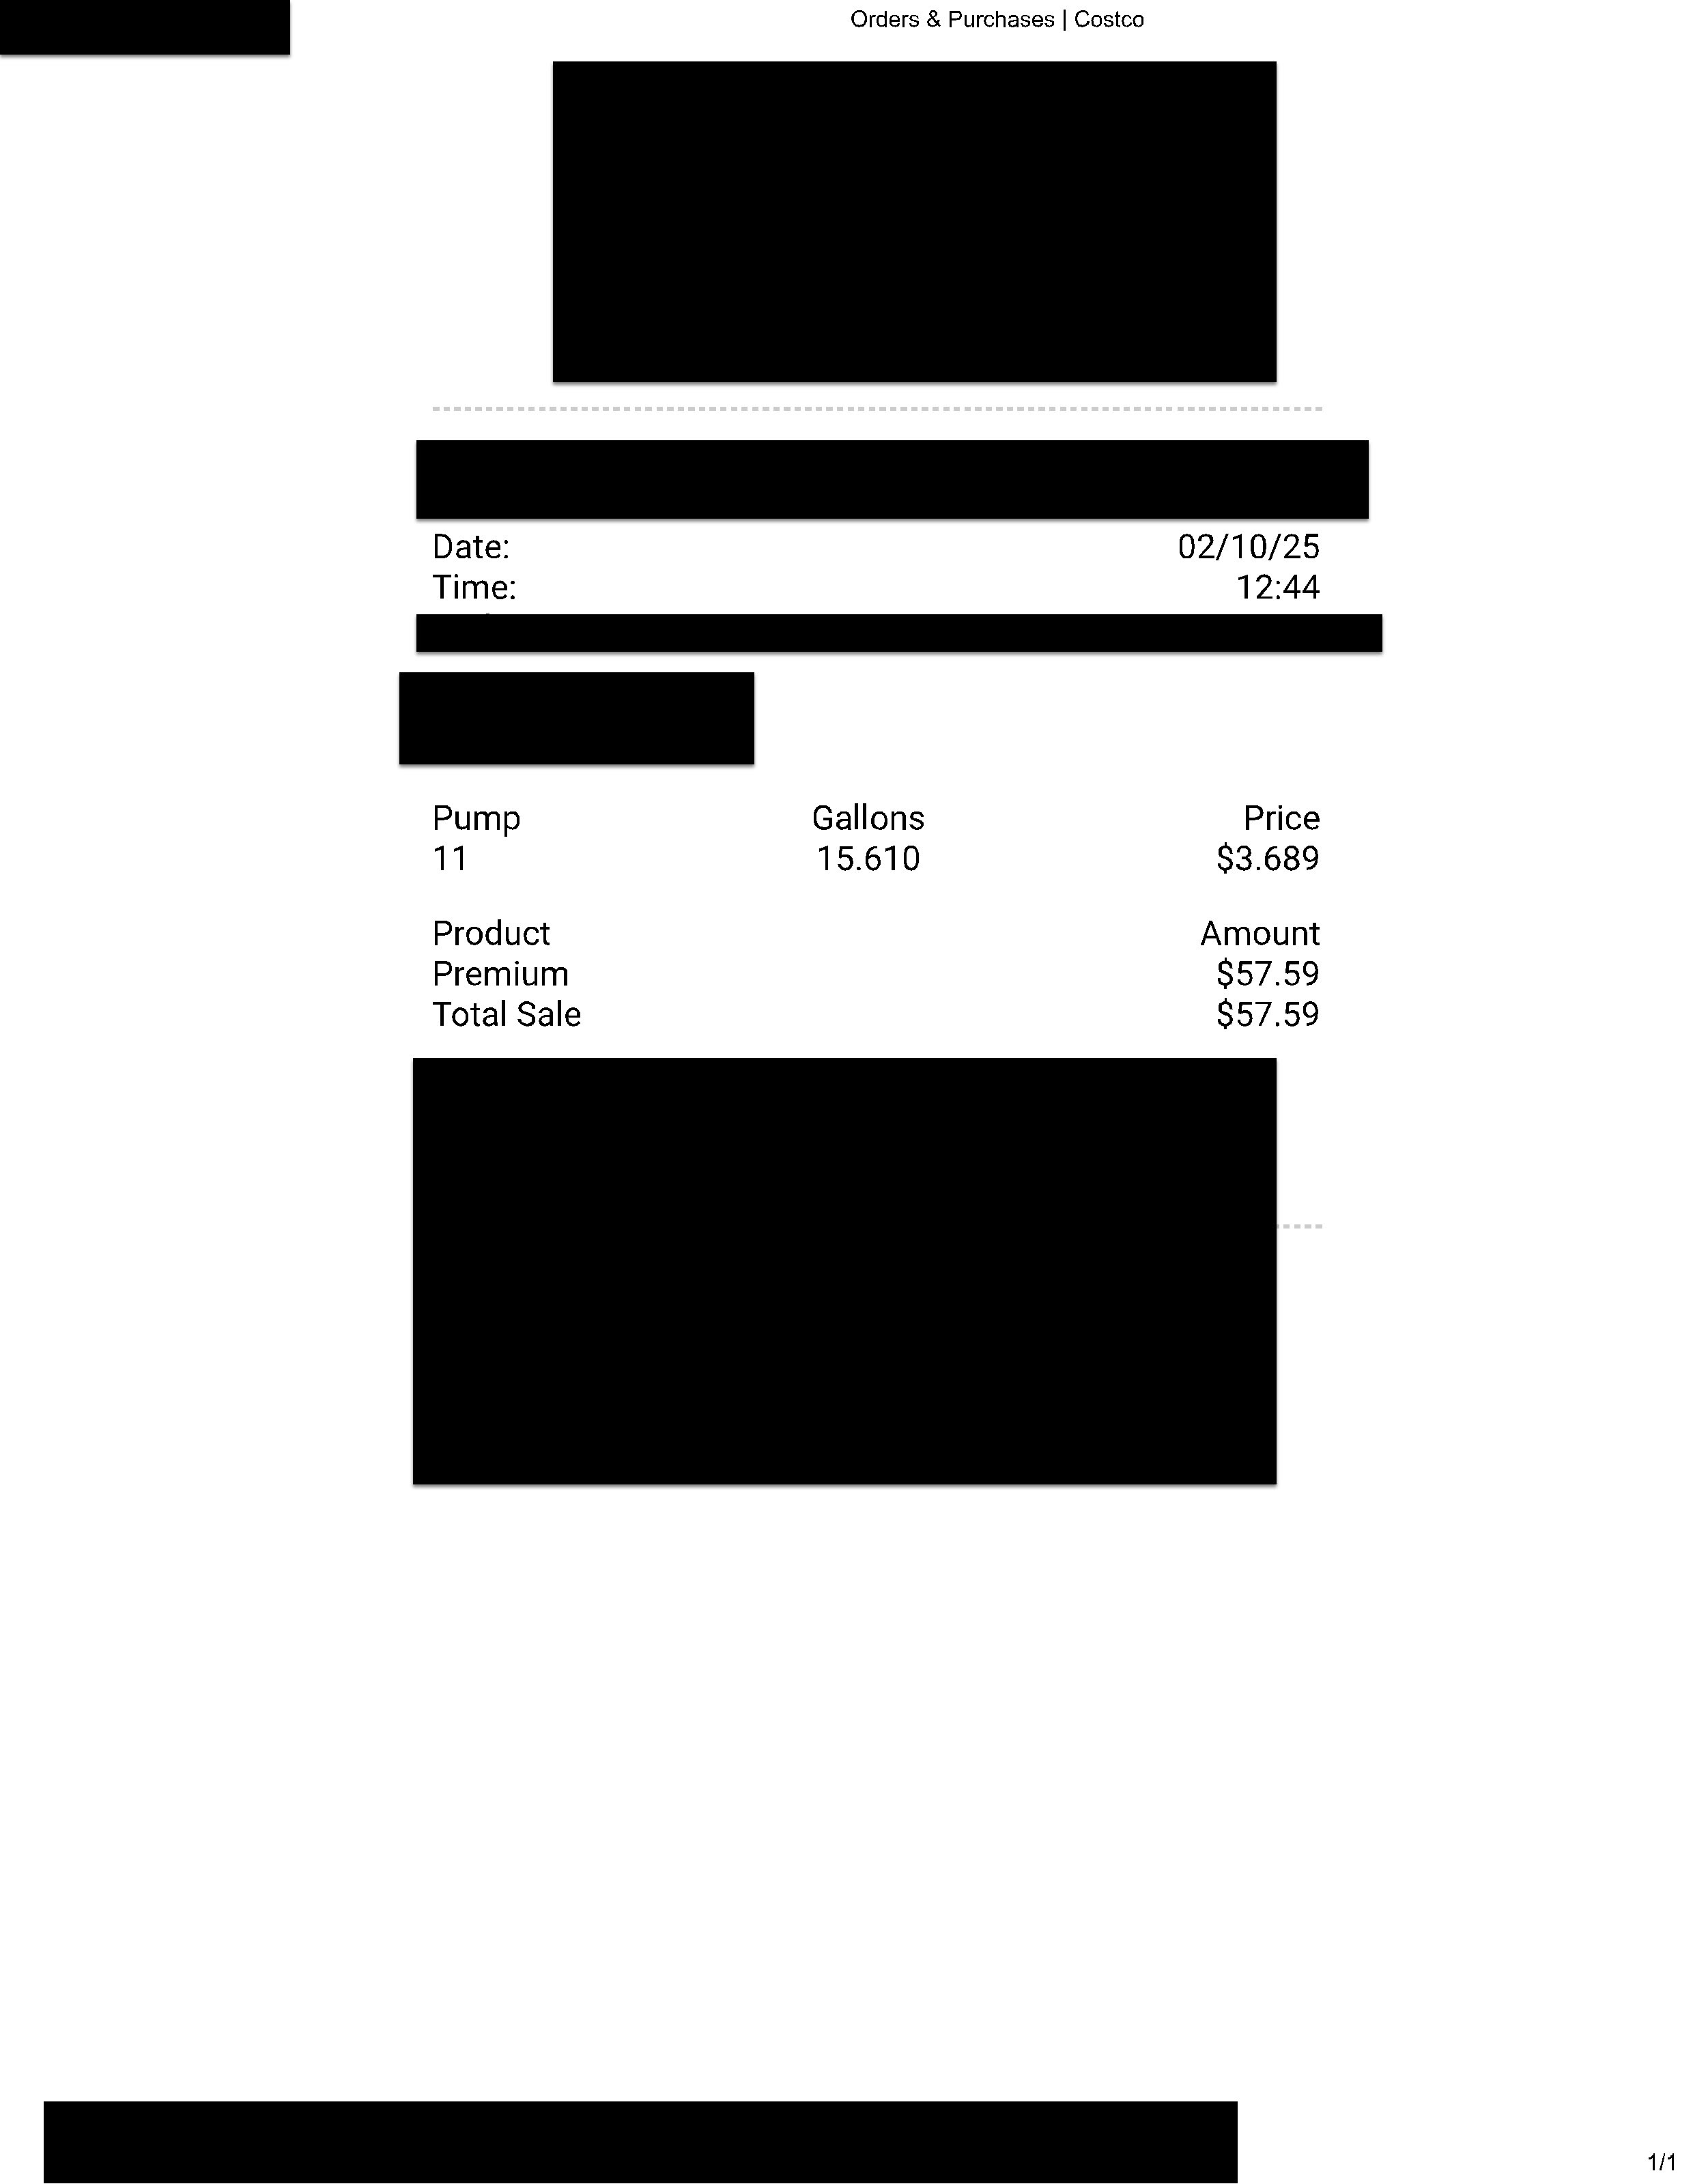

In [40]:
import os
from IPython.display import display
from PIL import Image

# Define the receipt folder
RECEIPT_FOLDER = "receipts"

# Ensure the folder exists
if not os.path.exists(RECEIPT_FOLDER):
    print(f"❌ Folder '{RECEIPT_FOLDER}' not found! Please place receipt images in this folder.")
else:
    print(f"📂 Found receipt folder: {RECEIPT_FOLDER}")

# Function to display receipt images
def display_receipt_images():
    receipt_files = [f for f in os.listdir(RECEIPT_FOLDER) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    
    if not receipt_files:
        print("⚠️ No receipt images found in the folder.")
        return

    for filename in receipt_files:
        image_path = os.path.join(RECEIPT_FOLDER, filename)
        print(f"🖼 Displaying: {filename}")
        display(Image.open(image_path))  # Directly display the image

# Display images at the top of the notebook
display_receipt_images()


In [ ]:
import easyocr
import os

# Initialize EasyOCR reader (English)
reader = easyocr.Reader(['en'])

# Define receipt folder
RECEIPT_FOLDER = "receipts"

# Ensure the folder exists
if not os.path.exists(RECEIPT_FOLDER):
    print(f"❌ Folder '{RECEIPT_FOLDER}' not found! Please place receipt images in this folder.")
else:
    print(f"📂 Found receipt folder: {RECEIPT_FOLDER}")

# Function to extract text using EasyOCR
def extract_text_easyocr(image_path):
    try:
        # Use EasyOCR to read text
        result = reader.readtext(image_path, detail=0)
        
        # Join extracted text into a single string
        return "\n".join(result)
    
    except Exception as e:
        return f"❌ Error processing {image_path}: {e}"

# Process each image in the receipts folder
for filename in os.listdir(RECEIPT_FOLDER):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(RECEIPT_FOLDER, filename)
        print(f"\n🖼 Processing: {filename}")

        # Extract text
        text = extract_text_easyocr(image_path)
        print(f"📝 Extracted Text:\n{text}\n" + "-"*50)

In [ ]:
import re

def structure_receipt_data(ocr_text, expected_items):
    structured_data = {
        "Date": None,
        "Amount": None,
        "Vendor": None,
        "Category": "Other",
        "Description": None
    }

    # Extract date
    date_match = re.search(r'(\d{2}/\d{2}/\d{2,4}|\d{4}-\d{2}-\d{2})', ocr_text)
    if date_match:
        structured_data["Date"] = date_match.group()

    # Extract total amount
    amount_match = re.search(r'(?:TOTAL|Total Sale|Amount:|PURCHASE AMOUNT:)\s*[S\$]?(\d+\.\d{2})', ocr_text, re.IGNORECASE)
    if amount_match:
        structured_data["Amount"] = amount_match.group(1)

    # Extract vendor
    lines = ocr_text.split("\n")
    vendor_index = next((i for i, line in enumerate(lines) if "Costco" in line), None)
    if vendor_index is not None:
        structured_data["Vendor"] = lines[vendor_index].strip()

    # Assign category
    for category, keywords in CATEGORY_KEYWORDS.items():
        if any(keyword.lower() in ocr_text.lower() for keyword in keywords):
            structured_data["Category"] = category

    # Enhanced filtering for product descriptions
    product_lines = []
    for line in lines:
        line = line.strip()
        for item in expected_items:
            if item.lower() in line.lower():
                product_lines.append(line)
                break

    structured_data["Description"] = ", ".join(product_lines)

    return structured_data

# Expected items for grocery and gas receipts
expected_grocery_items = ["YAKISOBA", "SPCY STRIPS", "ORANGES", "HVY CREAM", "MINI PEPPERS", "ORG FR EGGS", "KS BLUEBERRY", "GREEK YOGURT"]
expected_gas_items = ["Premium"]

# Apply the logic to each receipt
structured_receipt_1 = structure_receipt_data(sample_receipt_1, expected_grocery_items)
structured_receipt_2 = structure_receipt_data(sample_receipt_2, expected_gas_items)

print("📊 Structured Grocery Receipt:", structured_receipt_1)
print("📊 Structured Gas Receipt:", structured_receipt_2)

In [ ]:
import pandas as pd
import os

def save_data_to_csv(data, file_path='structured_receipts.csv'):
    # Convert the dictionary into a DataFrame
    df = pd.DataFrame([data])
    
    # Check if the CSV file exists
    try:
        if not os.path.exists(file_path):
            # Create a new CSV file and write the DataFrame
            df.to_csv(file_path, index=False)
            print(f"✅ Created new CSV file: {file_path} and data added.")
        else:
            # Load existing CSV and append new data using pd.concat()
            existing_df = pd.read_csv(file_path)
            updated_df = pd.concat([existing_df, df], ignore_index=True)
            updated_df.to_csv(file_path, index=False)
            print(f"✅ Data appended to existing CSV: {file_path}")
    except Exception as e:
        print(f"❌ Failed to save data to CSV: {e}")

# Example usage:
save_data_to_csv(structured_receipt_1)
save_data_to_csv(structured_receipt_2)

In [ ]:
import pandas as pd

# Load and display the CSV
df = pd.read_csv('structured_receipts.csv')

# Show the first few rows of the file
print("📄 Structured Receipts CSV:")
print(df.head())

In [ ]:
import pandas as pd
import os

def save_data_to_csv(data, file_path='structured_receipts.csv'):
    # Convert the dictionary into a DataFrame
    df = pd.DataFrame([data])
    
    # Ensure proper data formatting
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.strftime("%Y-%m-%d")  # Standardize date format
    df["Amount"] = df["Amount"].astype(str).str.replace(",", "").astype(float)  # Ensure amount is numeric
    
    # Handle missing values
    df.fillna("N/A", inplace=True)

    try:
        if not os.path.exists(file_path):
            df.to_csv(file_path, index=False)
            print(f"✅ Created new CSV file: {file_path} and data added.")
        else:
            # Load existing CSV and append new data
            existing_df = pd.read_csv(file_path)
            
            # Avoid duplicates (based on Date + Amount + Vendor)
            combined_df = pd.concat([existing_df, df], ignore_index=True)
            combined_df.drop_duplicates(subset=["Date", "Amount", "Vendor"], keep="last", inplace=True)
            
            combined_df.to_csv(file_path, index=False)
            print(f"✅ Data appended and cleaned in CSV: {file_path}")
    
    except Exception as e:
        print(f"❌ Failed to save data to CSV: {e}")

# Example usage:
save_data_to_csv(structured_receipt_1)
save_data_to_csv(structured_receipt_2)

In [ ]:
from crewai import Agent, Task, Crew
import pandas as pd
import os
import re

In [ ]:
# Define Crew AI Agents
# Agent 1: Expense Extractor
expense_extractor = Agent(
    role="Expense Extractor",
    goal="Extract detailed expense information from receipts, including vendor, date, and total cost.",
    backstory="An expert in financial data extraction, using AI to analyze receipts and transactions.",
    verbose=True
)

# Agent 2: Expense Categorizer
expense_categorizer = Agent(
    role="Expense Categorizer",
    goal="Classify expenses based on the vendor and purchase details, ensuring accurate financial records.",
    backstory="A finance expert specializing in expense tracking and categorization based on spending patterns.",
    verbose=True
)

# Agent 3: Financial Record Keeper
record_keeper = Agent(
    role="Financial Record Keeper",
    goal="Ensure structured expense tracking while detecting fraudulent transactions. If fraud is suspected, simulate contacting the bank to freeze the credit card.",
    backstory="An AI-driven finance assistant responsible for accurate transaction logging, fraud detection, and financial security.",
    verbose=True
)

In [ ]:
# Task 1: Extract Expenses from Receipts
extract_expenses_task = Task(
    description="Read receipts from the 'receipts/' folder and extract structured expense details.",
    agent=expense_extractor,
    expected_output="A dictionary containing structured receipt details, including Date, Vendor, Amount, and Items."
)

# Task 2: Categorize the Expenses
categorize_expenses_task = Task(
    description="Analyze extracted expense data and determine the correct category (e.g., Food, Transport, Shopping).",
    agent=expense_categorizer,
    expected_output="A dictionary with categorized expense details, including Date, Vendor, Amount, and Category."
)

# Task 3: Store Expenses in CSV
store_expenses_task = Task(
    description="Save the categorized expense data into 'structured_receipts.csv', ensuring proper formatting and no duplicates.",
    agent=record_keeper,
    expected_output="Updated structured_receipts.csv file containing the new expense details."
)

# Task 4: Detect Fraudulent Transactions (Mock)
detect_fraud_task = Task(
    description="Analyze recent transactions for fraud indicators. If suspicious activity is detected, simulate contacting the bank to freeze the card.",
    agent=record_keeper,
    expected_output="An alert message if a transaction is flagged as fraudulent, otherwise a confirmation of no fraud detected."
)

In [ ]:
def detect_fraud(transaction):
    """Simple fraud detection logic (mock version)."""
    suspicious = False
    reason = ""

    if transaction["Amount"] > 1000:
        suspicious = True
        reason = "High-value transaction detected."

    if "foreign" in transaction.get("Vendor", "").lower():
        suspicious = True
        reason = "Transaction from foreign vendor."

    if suspicious:
        print(f"🚨 Fraud Alert: {reason}")
        mock_contact_bank(transaction)

def mock_contact_bank(transaction):
    """Mock function to simulate contacting the bank."""
    print(f"📞 Contacting bank to freeze credit card due to suspicious transaction at {transaction['Vendor']}.")
    print(f"🚫 Credit Card Freeze Initiated (Mock) for transaction: {transaction}")

In [ ]:
# Create the Crew for Expense Management
expense_management_crew = Crew(
    agents=[expense_extractor, expense_categorizer, record_keeper],
    tasks=[extract_expenses_task, categorize_expenses_task, store_expenses_task, detect_fraud_task],
    verbose=True
)

# Run the Crew!
expense_management_crew.kickoff()